In [58]:
import geopandas as gpd
import rasterio
from importlib import reload
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import os
#import contextily as cx
import glob
import geoplot as gplt

# read world boundaries

In [60]:
world = gpd.read_file(gplt.datasets.get_path('world'))
geometries = []
for g in world.geometry:
    if 'geoms' in dir(g): 
        g = g.geoms[np.argmax([i.area for i in g.geoms])]
    geometries.append(g)

world['geometry'] = geometries


# random select a random chipset

In [80]:
basedir = "/opt/buckets/disasterbrain-data/chips/chipsets"
dataset = 's2rgb-2024'

files = glob.glob(f"{basedir}/*/{dataset}/*.tif")
chipsets = np.unique([file.split("/")[-3] for file in files])
chipsets

array(['14568b86148ad_partitions_aschips_0d022b0a6212a',
       '201065a43a4cf_partitions_aschips_0c375463e6316'], dtype='<U46')

In [82]:
chipset = np.random.choice(chipsets)
chipset

np.str_('201065a43a4cf_partitions_aschips_0c375463e6316')

In [107]:
#chipset = np.random.choice(chipsets)
files = glob.glob(f"{basedir}/*/{dataset}/*.tif")
chipset_files = [f for f in files if chipset in f]
z = gpd.read_file(f"{basedir}/{chipset}.geojson")
print ('chipset', chipset, 'has', len(chipset_files), 'chips downloaded, out of', len(z))


chipset 201065a43a4cf_partitions_aschips_0c375463e6316 has 2883 chips downloaded, out of 10102


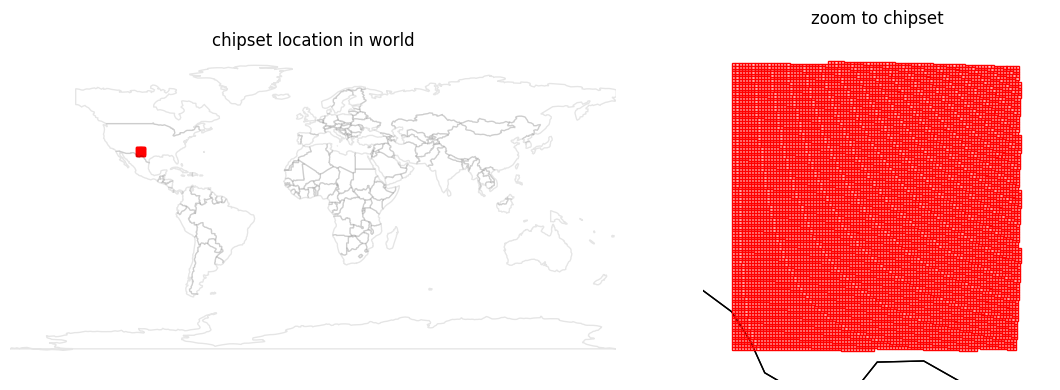

In [85]:
for ax,i in subplots(2, usizex=6, usizey=4):
    if i==0:       
        gplt.polyplot(z, alpha=.5, ax=ax, edgecolor='red')
        gplt.polyplot(world, alpha=0.1, ax=ax)
        plt.title('chipset location in world')
    else:
        gplt.polyplot(world, alpha=1, ax=ax)
        gplt.polyplot(z, alpha=1, ax=ax, edgecolor='red')
        plt.title('zoom to chipset')



# select a random chip within the chipset

In [109]:
chipset_file = np.random.choice(chipset_files)
identifier = chipset_file.split("/")[-1].split(".")[0]
c = z[z.identifier==identifier].iloc[0]
chipset_file

np.str_('/opt/buckets/disasterbrain-data/chips/chipsets/201065a43a4cf_partitions_aschips_0c375463e6316/s2rgb-2024/17073606cedaf.tif')

In [110]:
c

area_km2                                              26.206257
identifier                                        17073606cedaf
group                                                        12
geometry      POLYGON ((-104.1314560070207 34.86957251607071...
Name: 1850, dtype: object

In [111]:
z[z.identifier==identifier].explore()


# load chip and show channels

In [112]:
with rasterio.open(chipset_file) as f:
    x = f.read()
    d = f.descriptions
    p = f.profile.copy()
x.shape, x.dtype



((12, 512, 512), dtype('uint8'))

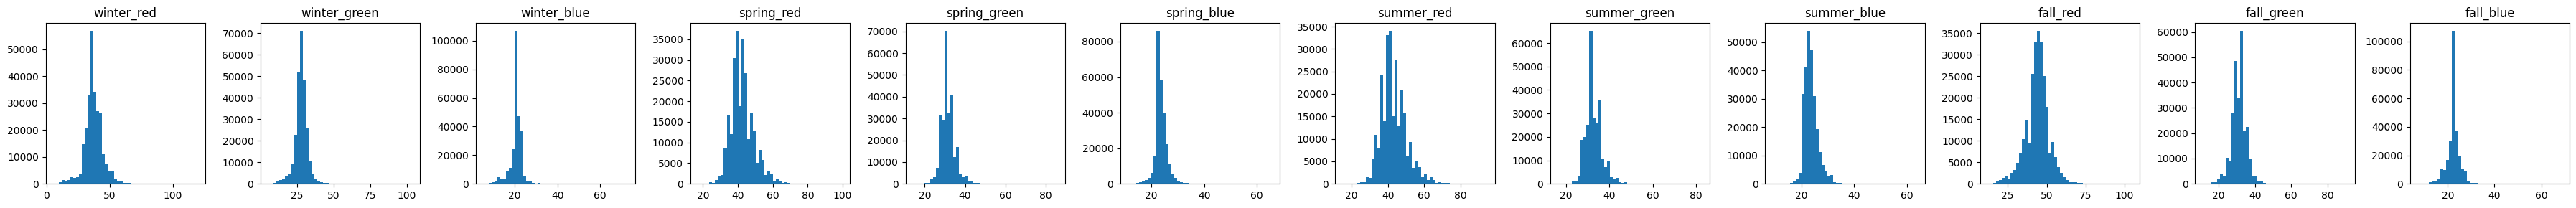

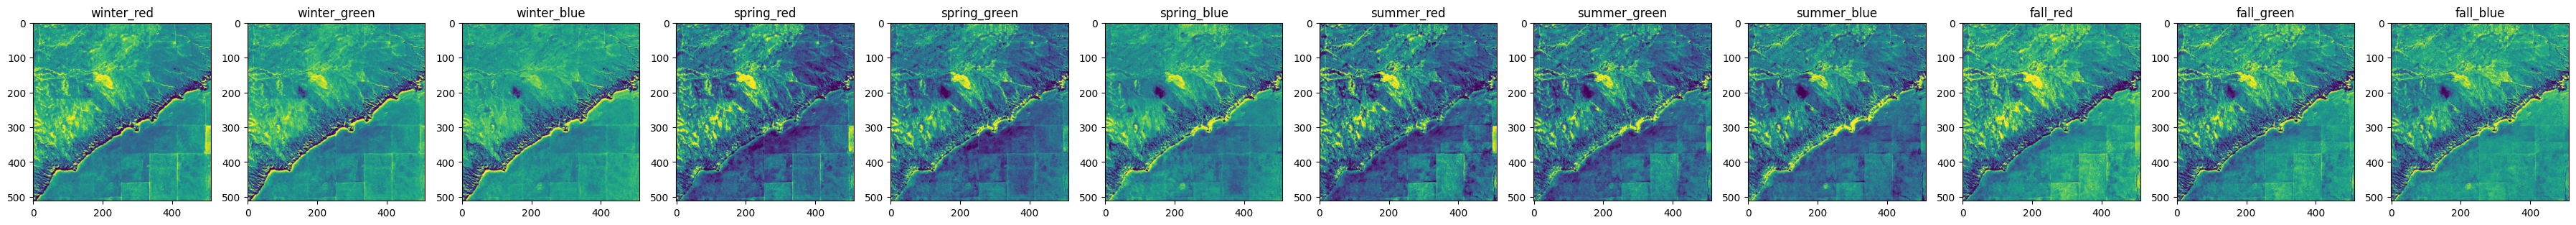

In [113]:
for ax,i in subplots(len(d), n_cols=12):
    plt.hist(x[i].flatten(), bins=50);
    plt.title(d[i])
    
for ax,i in subplots(len(d), n_cols=12):
    a,b = np.percentile(x[i], (1,99))
    plt.imshow(x[i], vmin=a, vmax=b)
    plt.title(d[i])

# show rgb for each season

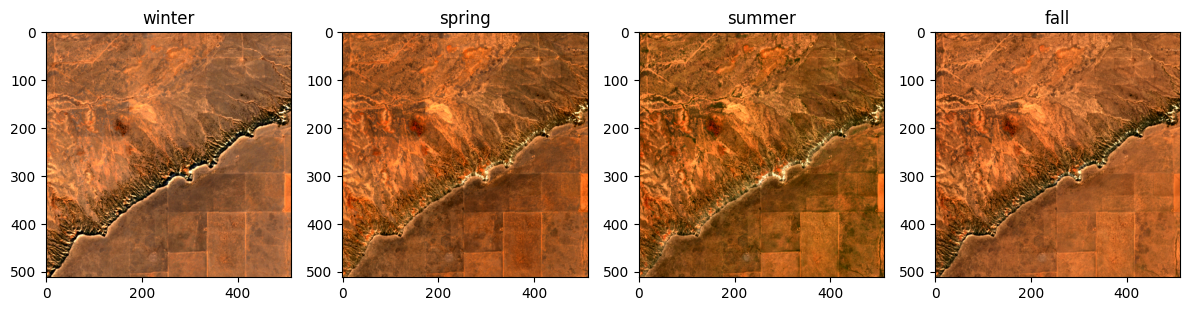

In [114]:
for ax,season in subplots(['winter', 'spring', 'summer', 'fall']):

    b4idx = np.argwhere(np.r_[list(d)] == f"{season}_red")[0,0]
    b3idx = np.argwhere(np.r_[list(d)] == f"{season}_green")[0,0]
    b2idx = np.argwhere(np.r_[list(d)] == f"{season}_blue")[0,0]
    xs = x[[b4idx, b3idx, b2idx]]
    xs = np.transpose(xs, [1,2,0]) / 255
    a,b = np.percentile(xs, (1,99))
    xs = (xs-a)/(b-a)
    xs[xs<0]=0
    xs[xs>1]=1
    plt.imshow(xs)
    plt.title(season)